In [31]:
from PIL import Image
import scipy as sp
import numpy as np
import scipy.signal as sn
import matplotlib.pyplot as plt
from skimage.feature import match_template
import matplotlib.cm as cm
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from sklearn.neighbors import KDTree

import os
import time
import argparse
import skimage.io
import scipy.optimize as opt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from skimage.feature import peak_local_max
import matplotlib.colors as colors
import photutils as pu
from photutils.background import Background
from sklearn.neighbors import KDTree
from scipy.ndimage.filters import gaussian_filter
import itertools

errmsgs = np.seterr(all='ignore') # silence warning messages about div-by-zero
%matplotlib notebook

In [2]:
def nnn_map(X, NN=4):
    """
    Takes any n-dimensional array X and returns NN nearest neighbors and distances in
    a format that helps with visualizing bonds between nearest neighbors
    
    Inputs: 
          X       : Array of coordinates
          NN      : Number of nearest neighbors to compute
    
    Outputs:
          idxbond : Format is below. Makes it easy to plot bonds.
                    ...
                    i  ,  nn1
                    i  ,  nn2
                    i  ,  nn3
                    ...
                    i  ,  nnNN
                    i+1,  nn1
                    ...
          
          bonddist:
                    ...
                    dist(i,nn1)
                    dist(i,nn2)
                    dist(i,nn3)
                    ...
                    dist(i, nnNN)
                    dist(i+1, nn1)
                    ...
    """  
    NN+=1
    
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    dist,idx=kdt.query(X, k=NN, return_distance=True)          
    
    idxbond=[]
    for i in idx:
        for j in itertools.product(np.array([i[0]]),np.array(i[1:])):
            idxbond.append(j)
    idxbond=np.array(idxbond)
    
    bonddist=[]        
    for i in dist:
        for j in itertools.product(np.array([i[0]]),np.array(i[1:])):
            bonddist.append(j)        
    bonddist=np.array(bonddist)
    bonddist=bonddist[:,1]
    return idxbond, bonddist

In [3]:
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()   

In [4]:
def to_rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return np.array([r, g, b])

In [5]:
def get_fft(im):
    return np.fft.fftshift(np.fft.fft2(im))

def get_ifft(f):
    return np.fft.ifft2(np.fft.fftshift(f))

def show_im(im, colormap=cm.Greys_r):
    fig,ax=plt.subplots()
    ax.imshow(im, origin='lower', interpolation='nearest', cmap=colormap)
    plt.show()
    return fig,ax

def show_fft(f):
    fig,ax = plt.subplots()
    ax.imshow(np.log(np.abs(f)**2+1), cmap=cm.Greys_r, origin='lower', interpolation='nearest')
    plt.show()


In [6]:
fwhm=6
npix=1000
scale=80
NN=5

In [7]:
A=Image.open('SUM_08_stack30_ADF130mm_1024_2.55Mx_1us_.100degRot_1.tif')
imarray=np.array(A)
imarray=imarray/np.std(imarray)
#Background Subtract
bkg = Background(imarray, (20, 20), filter_shape=(4, 4), method='median')
imbckgsub=imarray-bkg.background
#imbckgsub=imarray

#Find peak positions and intensities using daofind method
A=pu.daofind(imbckgsub,0,fwhm,exclude_border=True)
x=np.array(A.field(1))
y=np.array(A.field(2))
peakintensity=np.array(A.field(8))

#Find NN nearest neighbors for each peak
X=np.vstack((x,y)).T
kdt = KDTree(X, leaf_size=30, metric='euclidean')
dist,idx=kdt.query(X, k=NN, return_distance=True)          
dist=dist[:,1:]

In [19]:
plt.matshow(imarray, cmap=cm.Greys_r)
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.xticks([]) 
plt.yticks([]) 
plt.title('Unfiltered Image')


plt.matshow(bkg.background, cmap=cm.gist_heat)
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.title('Background')
plt.yticks([]) 
plt.xticks([]) 
plt.colorbar()


plt.matshow(imbckgsub,cmap=cm.jet)
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.yticks([]) 
plt.xticks([]) 
plt.title('Background Subtracted Image')

plt.figure()

plt.plot(x,y,'r.',ms=3.5)
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.xlim(0,800)
plt.ylim(0,800)
plt.xticks([]) 
plt.yticks([]) 
plt.imshow(imbckgsub, cmap=cm.Greys_r,interpolation='nearest')
plt.colorbar()
plt.title('Background Subtracted Image Overlaid with Gaussian Fitted Peaks')
plt.show()

In [9]:
#Assigning species by intensity
int_sep=2.02

idxA=peakintensity>int_sep
idxB=peakintensity<=int_sep

#Correcting for species assignment using structural/coordination prior
whereA=np.array(np.where(idxA==True)).ravel()
whereB=np.array(np.where(idxB==True)).ravel()

chemenA=[]
chemenB=[]
for i in idx:
    maskA=np.in1d(i,whereA)
    maskB=np.in1d(i,whereB)
    chemenA.append(maskA)
    chemenB.append(maskB)

chemenA=np.array(chemenA)
chemenA.astype(int)

chemenB=np.array(chemenB)
chemenB.astype(int)

#Outliers where a B-site (A-site) replaces an A-site (B-site)
idxoutliersA=np.sum(chemenA,1)==5
idxoutliersB=np.sum(chemenB,1)==5

outliersA=np.array(np.where(np.sum(chemenA,1)==5)).ravel()
outliersB=np.array(np.where(np.sum(chemenB,1)==5)).ravel()

idxACorrected=idxA-idxoutliersA+idxoutliersB
idxBCorrected=idxB-idxoutliersB+idxoutliersA

In [10]:
plt.imshow(imbckgsub, cmap=cm.Blues_r,interpolation='nearest')
plt.plot(x[idxA],y[idxA],'ro',ms=4.5)
plt.plot(x[idxB],y[idxB],'yo',ms=4.5)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.xticks([]) 
plt.yticks([]) 
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.title('First Pass')

plt.figure()
plt.imshow(imbckgsub, cmap=cm.Blues_r,interpolation='nearest')
plt.plot(x[idx[outliersA][:,0]],y[idx[outliersA][:,0]],'b*',ms=8)
plt.plot(x[idx[outliersB][:,0]],y[idx[outliersB][:,0]],'k*',ms=8)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.xticks([]) 
plt.yticks([]) 
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.title('Outlier Detection Using Nearest Neighbor')


plt.figure()
plt.imshow(imbckgsub, cmap=cm.Blues_r,interpolation='nearest')
plt.plot(x[idxACorrected],y[idxACorrected],'ro',ms=4.5)
plt.plot(x[idxBCorrected],y[idxBCorrected],'yo',ms=4.5)
plt.title('Detected Species With Nearest Neighbor Fix')
plt.plot(np.arange(npix-scale-10,npix-10), 20*np.ones(scale),'w-',ms=2,lw=4)
plt.xlim(0,npix)
plt.ylim(0,npix)
plt.xticks([]) 
plt.yticks([]) 

plt.show()

<p style="font-size:190%;"<b>Figures for M & M abstract</b>.</p>

In [11]:
#Intensity histograms of A+B and corrected A, B

bins = np.linspace(-.5, 6., 100)
plt.hist(peakintensity.ravel(),bins,histtype='bar',alpha=0.2,color='k',label='A & B')
plt.hist(peakintensity[idxACorrected],bins,histtype='step',lw=3,color='r',alpha=.5,label='A Only')
plt.hist(peakintensity[idxBCorrected],bins,histtype='step',lw=3,color='#00ced6',alpha=1,label='B Only')
plt.ylim(2,900)
plt.xlim(-.0,5.5)
plt.xticks([])
plt.yticks(np.arange(0,1000,200))

plt.xlabel('Intensity (a.u.)', fontsize=25.)
plt.ylabel('Counts',fontsize=25.)

p1, = plt.plot([0,0],'o',ms=10,color='k', label='A+B',alpha=0.3)
p2, = plt.plot([0,0],'o',ms=10,color='r',label='A sublattice')
p3, = plt.plot([0,0], 'o',ms=10,color='#00ced6',label='B sublattice')
plt.tick_params(labelsize=22)

# create the legend
lg=plt.legend([p1,p2, p3], ['A & B', 'A sublattice', 'B sublattice'], loc='best',numpoints=1,frameon=False,prop={'size':20})
lg.draw_frame=False
p1.set_visible(False)
p2.set_visible(False)
p3.set_visible(False)
#plt.legend(loc='upper right')
plt.savefig('Histogram_AB_sublattice.png', format='png')
plt.show()

In [12]:
#2016 M&M Abstract: Figure 2c,d: HAADF image + HAADF image overlaid with corrected A,B 
plt.imshow(imarray, cmap=cm.Greys_r,interpolation='nearest')

plt.xlim(200,400)
plt.ylim(200,400)
plt.plot(225,227,'s',ms=10)
plt.plot(242,244,'s',ms=10)

plt.xticks([]) 
plt.yticks([]) 
plt.plot(np.arange(364,390), 213*np.ones(26),'w-',ms=2,lw=7)
plt.text(363, 202, '1 nm', fontsize=18,fontweight='bold',color='white', withdash=False)
#plt.savefig('ADFwo.png', format='png')

plt.figure()
plt.imshow(imbckgsub, cmap=cm.Greys_r,interpolation='nearest')
plt.plot(x[idxACorrected],y[idxACorrected],'ro',ms=7.,alpha=0.5)
plt.plot(x[idxBCorrected],y[idxBCorrected],'o',color='#00ced6',ms=7.,alpha=0.7)
plt.xlim(200,400)
plt.ylim(200,400)
plt.xticks([]) 
plt.yticks([]) 
plt.plot(np.arange(364,390), 213*np.ones(26),'w-',ms=2,lw=7)
plt.text(363, 202, '1 nm', fontsize=18,fontweight='bold',color='white', withdash=False)
#plt.savefig('ADFwP.png', format='png')
plt.show()

<p style="font-size:190%;"<b>Displacement of B sublattice relative to COM of A sublattice</b>.</p>

In [19]:
#Generate displacement plot of B relative to center of mass of A sites
idxbulk=(x>20)*(y>20)*(x<npix-80)*(y<npix-80)
idxquiver=idxBCorrected*idxbulk

x_center=np.mean(x[idx[idxquiver][:,1:]],1)
y_center=np.mean(y[idx[idxquiver][:,1:]],1)

d=np.sqrt((x_center-x[idxquiver])**2+(y_center-y[idxquiver])**2)
theta=np.arctan(np.abs(y_center-y[idxquiver])/np.abs(x_center-x[idxquiver]) ) 


plt.quiver(x[idxquiver], y[idxquiver], x_center-x[idxquiver], y_center-y[idxquiver],d,
           units = 'xy',scale=0.1, width=2.8)
plt.xticks([])
plt.yticks([])

plt.xlim(0,npix)
plt.ylim(0, npix)

plt.title('B site Displacement Map')

plt.show()

In [19]:
#Write x,y coordinates of A,B sublattices
filename='08_Titan_BSCMO'
count=1
with open(filename, 'w+') as f:
    f.write('# BSCMO 26_stack5HAADF_fov30nm_t32us_1024px_SUM.tif\n')
    f.write('# A-Site x    A-site y    B-site x     B-site y\n')
    for (i,j,k,l) in zip(x[idxACorrected], y[idxACorrected], x[idxBCorrected],y[idxBCorrected]):
        f.write('% 9.4f   %9.4f    % 9.4f   %9.4f\n' %(i,j,k,l))
        

<p style="font-size:190%;"<b>Generate Gaussian Fake images</b>.</p>

In [50]:
xmin=0
xmax=1024

ymin=0
ymax=1024
xg = np.linspace(xmin,xmax ,xmax-xmin+1 )
yg = np.linspace(ymin, ymax, ymax-ymin+1)
xg, yg = np.meshgrid(xg, yg)

k=2

dataA=0
#create data
for (i,j) in zip(x[idxACorrected],y[idxACorrected]):
    dataA = dataA + twoD_Gaussian((xg, yg), k,i,j, 1.8, 1.8, 0)

dataB=0
#create data
for (i,j) in zip(x[idxBCorrected],y[idxBCorrected]):
    dataB = dataB + twoD_Gaussian((xg, yg), k, i,j, 1.4, 1.4, 0)

<IPython.core.display.Javascript object>


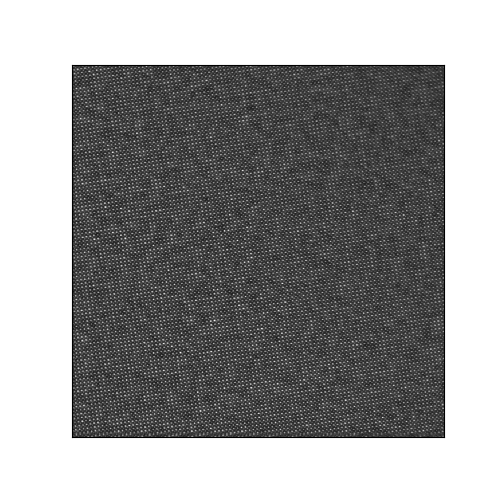

<IPython.core.display.Javascript object>


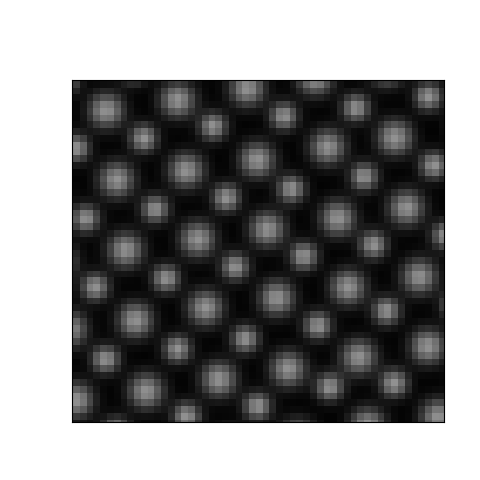

In [53]:
plt.matshow(imbckgsub[xmin:xmax,ymin:ymax], cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/ismail/Desktop/original_before_fit.png')
plt.matshow((dataA+dataB).reshape(ymax-ymin+1,xmax-xmin+1), cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/ismail/Desktop/original_after_fit.png')
import writetiff
writetiff.saveTiff((dataA+dataB).reshape(ymax-ymin+1,xmax-xmin+1), '/home/ismail/Desktop/fit_lattice_full')

In [28]:
#3D visualization of 2D image


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xg, yg, data, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.zaxis.limit_range_for_scale(0,10)
plt.xticks([])
plt.yticks([])
#fig.colorbar(surf, shrink=0.5, aspect=5,)
ax.zaxis.limit_range_for_scale(0,20)
ax.axis('off')
ax.set_axis_off()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

<p style="font-size:190%;"<b>Bond Length Mapping</b>.</p>

In [46]:
idxbulk=(x>20)*(y>20)*(x<npix-160)*(y<npix-160)

XA=np.vstack((x[idxBCorrected*idxbulk],y[idxBCorrected*idxbulk])).T
idxbondAA, bonddistAA=nnn_map(XA,8)

minbond=12.8
maxbond=16.6
idd1=bonddistAA>minbond 
idd2=bonddistAA<maxbond
cNorm  = colors.Normalize(vmin=minbond-np.mean(bonddistAA[idd1*idd2]), vmax=maxbond-np.mean(bonddistAA[idd1*idd2]))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.coolwarm)

In [47]:
plt.imshow(imbckgsub, cmap=cm.Blues, interpolation='nearest',alpha=0.5)

colorvalues=[]
for i,j in zip(idxbondAA, bonddistAA):
        if j>minbond and j<maxbond: 
        
            colorVal = scalarMap.to_rgba(j-np.mean(bonddistAA[idd1*idd2]))
            colorvalues.append(colorVal)
            plt.plot(XA[:,0][i], XA[:,1][i],'-',lw=2,color=colorVal) 
    
plt.plot(x[idxACorrected],y[idxACorrected],'r.', ms=3)
plt.plot(x[idxBCorrected],y[idxBCorrected],'b.', ms=3)
scalarMap.set_array(np.array(colorvalues))
plt.colorbar(scalarMap)
plt.xlim(30,820)
plt.ylim(30,820)
plt.title('BB bond lengths along CO modulation direction [101pc]')
plt.show()

<p style="font-size:190%;"<b>Fourier Filtering Analysis</b>.</p>

In [32]:
#FFT
f=get_fft(imbckgsub)
fftmag=np.log(np.abs(f)**2)

#Bragg Peak Detection
braggpk=pu.daofind(gaussian_filter(fftmag,4),4,12,exclude_border=True)
xbraggpk=np.array(braggpk.field(1))
ybraggpk=np.array(braggpk.field(2))

xbraggpk=np.append(xbraggpk,[512.])
ybraggpk=np.append(ybraggpk,[512.])

braggpkintensity=np.array(braggpk.field(8))

In [33]:
#Bragg Peak Indexing
idxcenterx=np.array(np.abs(xbraggpk-.5*np.shape(f)[0])<1e-2)
idxcentery=np.array(np.abs(ybraggpk-.5*np.shape(f)[0])<1e-2)

idxcenter= np.where(idxcenterx*idxcentery==True)
Xbragg=np.vstack((xbraggpk,ybraggpk)).T
kdtbragg = KDTree(Xbragg, leaf_size=30, metric='euclidean')
distbragg,idxbragg=kdtbragg.query(Xbragg, k=25, return_distance=True)          

In [34]:
#Bragg Peak Selection
pk=idxbragg[-1,6:8]
pk=np.array(pk)
plt.matshow(fftmag,cmap=cm.Greys_r)
plt.plot(xbraggpk,ybraggpk,'.')
plt.plot(xbraggpk[pk],ybraggpk[pk],'r.', ms=6)
plt.show()

In [23]:
# Make Hann window
f=get_fft(imarray)
radius = 15
hann = np.outer(np.hanning(2*radius+1),np.hanning(2*radius+1))
mask = np.zeros(np.shape(f))
try:
    for i in pk:
        mask[ybraggpk[i]-radius:ybraggpk[i]+radius+1,xbraggpk[i]-radius:xbraggpk[i]+radius+1] += hann
except TypeError:
    print "ERROR! Need to select +Q and -Q to filter. Proceeding but results will not be meaningful"
    mask[ybraggpk[pk]-radius:ybraggpk[pk]+radius+1,xbraggpk[pk]-radius:xbraggpk[pk]+radius+1] += hann

In [35]:
filtered_fft = f*mask
filtered_im = np.fft.ifft2(np.fft.ifftshift(filtered_fft))

plt.matshow(np.log(np.abs(filtered_fft)),cmap=cm.Greys_r)
plt.matshow(np.abs(filtered_im),cmap=cm.Greys_r)

plt.show()

NameError: name 'mask' is not defined

In [209]:
#Shift to Origin
f2=f.copy()

non = lambda s: s if s<0 else None
mom = lambda s: max(0,s)

ox, oy = -(xbraggpk[pk]-xbraggpk[idxcenter]), -(ybraggpk[pk]-ybraggpk[idxcenter]) 

shift_f2 = np.zeros_like(f2)
shift_f2[mom(oy):non(oy), mom(ox):non(ox)] = f2[mom(-oy):non(-oy), mom(-ox):non(-ox)]

In [206]:
#Circular Mask
shift_f2_an=shift_f2.copy()
shift_f2_circle=shift_f2.copy()

for i in np.linspace(-511.,511.,1024):
    for j in np.linspace(-511.,511.,1024): 
        if (i)**2 + (j-1)**2 > 3**2:
                shift_f2_an[512-i,512-j]=0
                shift_f2_circle[512-i,512-j]=0


In [245]:
plt.imshow(imbckgsub  ,cmap=cm.Greys, interpolation='nearest', )
plt.imshow(np.abs(ftimage_an)  ,cmap=cm.Greys_r, interpolation='nearest', alpha=1.00)
plt.colorbar()
plt.plot(x[idxBCorrected],y[idxBCorrected],'ko',ms=2)
plt.xticks([])
plt.yticks([])
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

<p style="font-size:190%;"<b>Generate a lattice + structural modulation and calculate the FFT</b>.</p>

In [2]:
from structure import UnitCell
from structure import Supercell

In [3]:
def recipTransform(posX, posY, a, kmax, N):
    #Take the reciprocal transform of a series of delta functions at posX, posY
    #posY and posX and 'a' need to be equal length

    kx=np.arange(-kmax,(kmax-kmax/N),kmax/N)
    ky=np.arange(-kmax,(kmax-kmax/N),kmax/N)
    kx,ky=np.meshgrid(kx,ky)               

    zz = np.zeros(np.size(kx,1)) + 0*1j
    for j in np.arange(0,np.size(posX)):
        zz = zz + np.exp( 2*np.pi*1j * ((posX[j]*kx)+(posY[j]*ky)) )
    return kx,ky,zz 

In [117]:
A=UnitCell('0.5 0.5 0.5 ', ['B'], 10)
B=Supercell(A,np.array([[90,0,0],[0,90,0],[0,0,1]]))
Bcoords=B.coords
xB=Bcoords[:,0]*1024.
yB=Bcoords[:,1]*1024.
plt.plot(xB,yB,'.')
plt.show()

In [624]:
modux=np.sin(((2.*np.pi/10)*0.333333*xB+np.pi/4))
plt.plot(modux,'.')
plt.show()

In [173]:
plt.plot(xB,yB,'.',ms=6)
plt.plot(xB+0.9*modux,yB,'k.',ms=6)
plt.show()

In [174]:
kx,ky,zz=recipTransform((xB+0.8*modux),yB,1,1./7.,256.)

<p style="font-size:190%;"<b>Generate a lattice + structural modulation fake image and take the FFT</b>.</p>

In [145]:
A_fakeimg=UnitCell('0.5 0.5 0.5 ', ['B'], 4)
B_fakeimg=Supercell(A_fakeimg,np.array([[90,0,0],[0,90,0],[0,0,1]]))
B_fakeimg_coords=B_fakeimg.coords*B_fakeimg.lattice_vectors[0][0]
xB_fakeimg=B_fakeimg_coords[:,0]
yB_fakeimg=B_fakeimg_coords[:,1]
plt.plot(xB_fakeimg,yB_fakeimg,'.')
plt.show()

In [146]:
deltax=np.sin(((2.*np.pi/4.)*(.334)*xB_fakeimg))
deltay=np.sin(((2.*np.pi/4.)*(.334)*yB_fakeimg))

In [122]:
def rotate_lattice(lattice,theta=np.pi/60):

    rot=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    rotcoords=np.dot(rot, lattice.T).T
    xB_rot=rotcoords[:,0]
    yB_rot=rotcoords[:,1]

    maxx=np.max(xB_rot)
    minx=np.min(xB_rot)
    maxy=np.max(yB_rot)
    miny=np.min(yB_rot)

    #Find the corners of the rotated square relative to original lattice vectors
    ymaxx=yB_rot[np.where(np.abs(xB_rot-maxx)<1e-14)]
    yminx=yB_rot[np.where(np.abs(xB_rot-minx)<1e-14)]
    xminy=xB_rot[np.where(np.abs(yB_rot-miny)<1e-14)]
    xmaxy=xB_rot[np.where(np.abs(yB_rot-maxy)<1e-14)]

    idx1=xB_rot-xmaxy<1e-14
    idx2=xB_rot-xminy>1e-14
    idx3=yB_rot-ymaxx>1e-14
    idx4=yB_rot-yminx<1e-14
    idx_crop=idx1*idx2*idx3*idx4
    
    return xB_rot[idx_crop],yB_rot[idx_crop]

In [147]:
xB_modulated=xB_fakeimg+0.05*deltax
yB_modulated=yB_fakeimg+0.05*deltay

XY=np.vstack((xB_modulated,yB_modulated)).T
xb_rot_mod,yb_rot_mod=rotate_lattice(XY,np.pi/50)
plt.quiver(xB_fakeimg, yB_fakeimg, xB_modulated-xB_fakeimg, yB_modulated-yB_fakeimg,scale=7,width=.0020)
plt.plot(xB_fakeimg,yB_fakeimg,'bo',ms=2)
plt.xlim(100,200)
plt.ylim(100,200)
plt.figure()
plt.plot(1024./np.max(xb_rot_mod)*xb_rot_mod, 1024./np.max(yb_rot_mod)*yb_rot_mod,'b.')
#plt.plot(xB_modulated,yB_modulated,'k.',ms=8)
plt.show()

In [574]:
xg_fake = np.linspace(75,1023 ,1023-75+1)
yg_fake = np.linspace(75, 1023, 1023-75+1)
xg_fake, yg_fake = np.meshgrid(xg_fake, yg_fake)

dataFake=0
#create data
for (i,j) in zip(1024./np.max(xb_rot_mod)*xb_rot_mod,1024./np.max(yb_rot_mod)*yb_rot_mod):
    dataFake = dataFake + twoD_Gaussian((xg_fake, yg_fake), 0.7+(np.random.rand(1)-0.5)/5.,i,j, 2.3, 2.3, 0)


In [567]:
plt.matshow((dataFake+0.0*np.random.poisson(dataFake)).reshape(1024-75,1024-75), cmap=cm.Greys_r)
plt.savefig('test.tif', format='tif')
plt.show()

In [575]:
fftFake=sp.fftpack.fft2(dataFake.reshape(1024-75,1024-75)[20:,20:])
fftFake=sp.fftpack.fftshift(fftFake)
pwrsp=np.abs(fftFake)**2

plt.matshow(gaussian_filter(np.log(pwrsp+2),1.0),cmap=cm.Greys_r)
plt.colorbar()

plt.show()

<p style="font-size:190%;"<b>Modulations relative to an ideal lattice (Ismail/Ben/Robby)</b>.</p>

In [9]:
from scipy.io import loadmat
from periodcolor import anglemap

In [10]:
mat=loadmat('SUM_08_atomtrack_fullfov.mat')

In [11]:
X0=np.array(mat['x0_bragg']).ravel()
Y0=np.array(mat['y0_bragg']).ravel()

U=np.array(mat['x0_bragg']).ravel()-np.array(mat['x0']).ravel()
V=np.array(mat['y0_bragg']).ravel()-np.array(mat['y0']).ravel()

d=np.abs(U+1j*V)
theta=np.angle(U+1j*V )

idx1=X0>50
idx2=X0<950
idx3=Y0>50
idx4=Y0<950
idx=idx1*idx2*idx3*idx4

q=0

idxd=d[idx]<.5


In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


f, ( ax1, ax2) = plt.subplots(1, 2)


ax1.imshow(imarray, cmap=cm.Greys_r, interpolation='nearest', alpha=0.01)
im1=ax1.scatter(X0[idx]-1,Y0[idx]-1,c=(theta[idx]+np.angle(q)),s=50*((d[idx])**0.5), cmap=anglemap,lw=0)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(0,1024)
ax1.set_ylim(0,1024)
div = make_axes_locatable(ax1)
cax1 = div.append_axes("right", size="6%", pad=0.03)
f.colorbar(im1, cax=cax1,format="%.3g")

ax2.imshow(imarray, cmap=cm.Greys_r, origin='lower', interpolation='nearest', alpha=0.1)
im2=ax2.scatter(X0[idx]-1,Y0[idx]-1,s=10*(-theta[idx]),lw=0, color='#6280E2')
#im2=ax2.scatter(X0[idx][idxd]-1,Y0[idx][idxd]-1,s=(8*theta[idx]), color='k')

ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_xlim(0,1024)
ax2.set_ylim(0,1024)
#div = make_axes_locatable(ax2)
#cax2 = div.append_axes("right", size="6%", pad=0.03)
#f.colorbar(im2, cax=cax2,format="%.3g")
plt.show()

In [156]:
plt.hist(d[idx].ravel(),50)
plt.show()

In [13]:
show_im(imarray)
plt.plot(np.array(mat['x0']).ravel()-1,np.array(mat['y0']).ravel()-1,'k.',ms=3)
plt.quiver( X0[idx]-1, Y0[idx]-1, 
           U[idx],V[idx],
           theta[idx],
           scale=20, units='width', cmap=cm.coolwarm)
plt.colorbar()
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

In [896]:
plt.matshow(imarray, cmap=cm.Greys_r)
plt.plot(np.array(mat['x0']).ravel()-1,np.array(mat['y0']).ravel()-1,'b.',ms=5)
plt.plot(x[idxACorrected], y[idxACorrected],'w.',ms=5)
plt.show()

In [18]:
plt.hist(d[idx].ravel(),100)
plt.show()
idx2=d[idx]<.5

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns
import matplotlib.colors as col

##### generate custom colormap
def mkcmap(): 
    white = '#ffffff'
    black = '#000000'
    #red = '#ff0000'
    red='#AA385E'
    #blue = '#0000ff'
    blue='#6280E2'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

anglemap = mkcmap()
#huslmap = col.ListedColormap(sns.color_palette("husl",512))

f, ( ax1, ax2) = plt.subplots(1, 2)


ax1.imshow(imarray, cmap=cm.Greys_r, origin='lower', interpolation='nearest')
im1=ax1.scatter(X0[idx][idxd]-1,Y0[idx][idxd]-1,c=d[idx][idxd], cmap=cm.YlOrRd)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(0,1024)
ax1.set_ylim(0,1024)

div = make_axes_locatable(ax1)
cax1 = div.append_axes("right", size="6%", pad=0.03)
f.colorbar(im1, cax=cax1,format="%.3g")
#plt.colorbar()
ax2.matshow(imarray, cmap=cm.Greys_r)
im2=ax2.scatter(X0[idx]-1,Y0[idx]-1,c=theta[idx] ,cmap=anglemap)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_xlim(0,1024)
ax2.set_ylim(0,1024)
div = make_axes_locatable(ax2)
cax2 = div.append_axes("right", size="6%", pad=0.03)
f.colorbar(im2, cax=cax2,format="%.3g")
plt.show()

In [65]:
f2, ( ax7, ax8) = plt.subplots(1, 2)

ax7.matshow(imarray, cmap=cm.Greys_r)
im7=ax7.scatter(X0[idx][idx2]-1,Y0[idx][idx2]-1,c=d[idx][idx2], cmap=cm.YlOrRd)
div = make_axes_locatable(ax7)
cax7 = div.append_axes("right", size="6%", pad=0.03)
f2.colorbar(im7, cax=cax7,format="%.3g")
ax7.set_yticks([])
ax7.set_xticks([])
ax7.set_xlim(50,950)
ax7.set_ylim(50,950)

ax8.matshow(imbckgsub, cmap=cm.Greys_r)
im8=ax8.scatter(2,2,1, cmap=cm.Greys_r)
div = make_axes_locatable(ax8)
cax8 = div.append_axes("right", size="6%", pad=0.03)
#f2.colorbar(im8, cax=cax8,format="%.3g")
ax8.set_yticks([])
ax8.set_xticks([])
ax8.set_xlim(50,950)
ax8.set_ylim(50,950)

plt.grid()
plt.show()

/home/ismail/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7411 but corresponding boolean dimension is 9391


IndexError: index 7411 is out of bounds for axis 1 with size 7411

In [66]:
plt.matshow(imarray, cmap=cm.Greys_r)
plt.xlim(0,1000)
plt.ylim(0,1000)

plt.show()

In [20]:
f11, ax11 = plt.subplots(1, 1)

ax11.matshow(imarray, cmap=cm.Greys_r,alpha=1, interpolation='nearest', origin='lower')
im11=plt.scatter(X0[idx][idx2]-1,Y0[idx][idx2]-1,c=theta[idx][idx2],s=8, cmap=anglemap)
div = make_axes_locatable(ax11)
cax11 = div.append_axes("right", size="6%", pad=0.03)
f11.colorbar(im11, cax=cax11,format="%.3g")
ax11.set_yticks([])
ax11.set_xticks([])
ax11.set_xlim(0,1024)
ax11.set_ylim(0,1024)
plt.savefig('test.png', format='png')
plt.show()

In [67]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, (ax3, ax4) = plt.subplots(1, 2)

ax3.matshow(imarray, cmap=cm.Greys, alpha=.5)
ax3.plot(np.array(mat['x0']).ravel()-1,np.array(mat['y0']).ravel()-1,'k.',ms=3)
im3=ax3.quiver( X0[idx][idx2]-1, Y0[idx][idx2]-1, 
           U[idx][idx2],V[idx][idx2],
           theta[idx][idx2],
           scale=19, units='width', cmap=anglemap)
ax3.set_xlim(50,950)
ax3.set_ylim(0,1000)
div = make_axes_locatable(ax3)
cax3 = div.append_axes("right", size="5%", pad=0.05)
f.colorbar(im3, cax=cax3,format="%.3g")

ax4.matshow(imarray, cmap=cm.Greys_r)
im4=ax4.scatter(X0[idx]-1,Y0[idx]-1,c=theta[idx], cmap=anglemap)
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_xlim(0,1000)
ax4.set_ylim(0,1000)
div = make_axes_locatable(ax4)
cax4 = div.append_axes("right", size="5%", pad=0.05)
f.colorbar(im4, cax=cax4,format="%.3g")

plt.show()

/home/ismail/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7411 but corresponding boolean dimension is 9391


IndexError: index 7411 is out of bounds for axis 1 with size 7411

<p style="font-size:190%;"<b>Lock-In Phase Detection Method</b>.</p>

In [68]:
def create_center_mask(npix=1024,radius=10):
    mask=np.zeros((npix,npix))
    for i in np.linspace(-npix/2.+1.,npix/2., npix):
            for j in np.linspace(-npix/2.+1.,npix/2., npix):
                if (i)**2 + (j)**2 < (radius)**2:
                    mask[npix/2.-i,npix/2.-j]=1
    return mask

In [69]:
def generate_ref_image(qx,qy, npix=1024):
    cosRef=np.zeros((npix,npix))
    sinRef=np.zeros((npix,npix))

    for i in np.arange(0,npix-1):
            for j in np.arange(0,npix-1):
                cosRef[i,j]=np.cos(qx*j + qy*i)
                sinRef[i,j]=np.sin(qx*j + qy*i)
    
    return cosRef, sinRef 

In [70]:
def _shift_to_origin(tmp, x0,y0,xf,yf):
    non = lambda s: s if s<0 else None
    mom = lambda s: max(0,s)
    ox, oy = -(xf-x0), -(yf-y0) 
    shift_tmp = np.zeros_like(tmp)
    shift_tmp[mom(oy):non(oy), mom(ox):non(ox)] = tmp[mom(-oy):non(-oy), mom(-ox):non(-ox)]
    return shift_tmp

In [71]:
def create_mask(x,y, radius=15, masktype='hann',npix=1024):
    
    hann = np.outer(np.hanning(2*radius+1),np.hanning(2*radius+1))
    mask = np.zeros((npix,npix))+0.0*1j
    try:
        for i,j in zip(x,y):
            mask[j-radius:j+radius+1,i-radius:i+radius+1] += hann
    except TypeError:
        print "ERROR! Need to select +Q and -Q to filter. Proceeding but results will not be meaningful"
        mask[y-radius:y+radius+1,x-radius:x+radius+1] += hann

    return mask


In [72]:
def create_circle_mask(x,y,radius=10,npix=1024):
    mask=np.zeros((npix,npix))
    for x0,y0 in zip(x,y):
        for i in np.linspace(0.,npix-1, npix):
            for j in np.linspace(0.,npix-1, npix):
                if (i-x0)**2 + (j-y0)**2 < (radius)**2:
                    mask[j,i]=1
    return mask    

In [73]:
im=imbckgsub.copy()
xsize,ysize=np.shape(im)
npix=xsize
radius=50

#Select peaks
pk=idxbragg[-1,5]

plt.imshow(gaussian_filter(fftmag,2),cmap=cm.Greys_r, origin='lower', interpolation='nearest')
plt.plot(xbraggpk,ybraggpk,'b.')
plt.plot(xbraggpk[pk],ybraggpk[pk],'r.',ms=6)
plt.xlim(0,xsize)
plt.ylim(0,ysize)
plt.show()

NameError: name 'idxbragg' is not defined

In [51]:
#q-vectors
qx=2*np.pi*(xsize/2.-xbraggpk[pk])/xsize
qy=2*np.pi*(ysize/2.-ybraggpk[pk])/ysize

In [50]:
#Generate mask
mask=create_mask(xbraggpk[pk],ybraggpk[pk], radius,npix=xsize)
maskinner=create_circle_mask(xbraggpk[pk],ybraggpk[pk], radius=7)
maskouter=create_mask(xbraggpk[pk],ybraggpk[pk], radius=10)


#Get Fourier filtered image
filtered_im=get_ifft(get_fft(im)*maskouter)
show_im(np.abs(filtered_im), colormap=cm.coolwarm)
show_fft(get_fft(im)*maskouter)

ERROR! Need to select +Q and -Q to filter. Proceeding but results will not be meaningful


TypeError: zip argument #1 must support iteration

In [91]:
#plt.title('Filtered Image Z(r)')

#Generate reference images
    #Pick  +qx,+qy and forget about -qx,-qy
cosRef,sinRef=generate_ref_image(qx[0],qy[0],xsize)
tmp1,tmp2=show_im(cosRef[200:300,200:300])
#plt.title('Reference Image: cos(q.r)')
show_im(sinRef[200:300,200:300])
#plt.title('Reference Image: sin(q.r)')
#plt.show()

(<matplotlib.figure.Figure at 0x7f1f4e7477d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1f5412d250>)

In [97]:
#Multiply reference images with Fourier filtered images
outA=cosRef*(filtered_im)
outB=sinRef*(filtered_im)

show_im(np.abs(outA)[100:200,100:200], colormap=cm.coolwarm)
#plt.title('X(r)=cos(q.r)*Z(r)')
show_im(np.abs(outB), colormap=cm.coolwarm)
#plt.title('Y(r)=sin(q.r)*Z(r)')


#Take fft of output channels
fftoutA=get_fft(outA)
fftoutB=get_fft(outB)

#Low-pass filter the product images
low_pass=create_center_mask(npix=xsize,radius=50)
ifftA=get_ifft(fftoutA*low_pass)
ifftB=get_ifft(fftoutB*low_pass)

plt.matshow(np.abs(ifftA), cmap=cm.coolwarm)
#plt.title('Low Pass Filtered Xp(r)')
plt.matshow(np.abs(ifftB), cmap=cm.coolwarm)
plt.title('Low Pass Filtered Yp(r)')

#Get the phase shift (distortions from reference images)
final=np.abs(ifftA)+1j*np.abs(ifftB)
theta_lf=np.angle(final)

plt.matshow(theta_lf, cmap=cm.coolwarm)
plt.title('Phase Shift Image')
plt.colorbar()

#Get the total phase which includes q-vector phase modulation
phi=np.zeros((npix,npix))
for i in np.arange(0,npix-1):
    for j in np.arange(0,npix-1):
        phi[i,j] = (qx[0]*i + qy[0]*j - np.pi/2.+theta_lf[i,j])%2*np.pi

plt.matshow(phi, cmap=cm.coolwarm)

plt.title('Total Phase Image: phi(r)=cos(q.r+theta)')
plt.colorbar()
plt.show()

In [193]:
tmp=theta_lf.copy()

In [209]:
plt.matshow((-tmp+theta_lf)[100:900,100:900], cmap=cm.coolwarm)
plt.colorbar()
plt.show()


In [219]:
plt.matshow(np.gradient((theta_lf-tmp))[0]+np.gradient((theta_lf-tmp))[1], cmap=cm.coolwarm)
#plt.colorbar()

plt.quiver( X0[idx][idx2]-1, Y0[idx][idx2]-1, 
           U[idx][idx2],V[idx][idx2],
           theta[idx][idx2],
           scale=20, units='width', cmap=anglemap)
plt.title('Phase Shift Image')
plt.xlim(100,900)
plt.ylim(100,900)
plt.show()

In [2]:
import paircorrelation

In [224]:
g_r, r, reference_indices=paircorrelation.pairCorrelationFunction_2D(x[idxACorrected],y[idxACorrected],1024.,80.,.07)
g_r1, r1, reference_indices=paircorrelation.pairCorrelationFunction_2D(x[idxBCorrected],y[idxBCorrected],1024.,80.,.07)

X_real=np.array(mat['x0']).ravel()
Y_real=np.array(mat['y0']).ravel()

g_r2, r2, reference_indices=paircorrelation.pairCorrelationFunction_2D(X0,Y0,1024.,80.,.07)

In [226]:
plt.plot(.385*r,g_r1,'b',lw=2.2)
plt.plot(.385*r,g_r+12., 'k', lw=2.2)
plt.plot(.385*r,g_r2/2+24.,'r',lw=2.2)


plt.legend(['B Site', 'A Site','A_ideal'])
plt.ylim(-1,50)
plt.xlim(.385*7,.385*80)
plt.xlabel('r (Angstrom)')
plt.ylabel('RDF')
plt.show()

In [227]:
g_r, r, reference_indices=paircorrelation.pairCorrelationFunction_2D(xB_fakeimg,yB_fakeimg,350.,20.,.02)
g_r1, r1, reference_indices=paircorrelation.pairCorrelationFunction_2D(xB_modulated,yB_modulated,350.,20.,.02)


In [229]:
plt.plot(r,g_r, 'k.-', lw=2)
plt.plot(r,g_r1,'b.-',lw=1)
#plt.ylim(-1,30)
plt.legend(['Cubic', 'Modulated'])
plt.show()



In [28]:
plt.matshow(gaussian_filter(imarray,.8), cmap=cm.coolwarm)
s=sp.signal.fftconvolve(gaussian_filter(imarray,.8),gaussian_filter(imarray,.8))
np.shape(s)

(999, 559)

In [60]:
a=np.linspace(0,499,500)
b=np.linspace(0,279,280)

In [61]:
a,b=np.meshgrid(a,b)

In [62]:
a=499-a
b=499-b

In [75]:
plt.matshow(s[499:,279:])
plt.matshow((a*b).T)
plt.show()

In [85]:
plt.matshow(((s[499:,279:]/np.max(s[499:,279:]))/((a*b).T/np.max((a*b).T)))[0:200,0:200])
plt.show()

In [3]:
paircorrelation.pairCorrelationFunction_2D?